# Lesion classification

In [1]:
import sys 
import os
sys.path.append(os.path.abspath("/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn"))

from data import isic_archive_load
from auc_metric import calculate_auc
from gradcam import display_gradcam, make_gradcam_heatmap, get_img_array
from fractal.perc import FractalImage

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from IPython.display import Image, display

In [3]:
tf.get_logger().setLevel('ERROR')

### Model description

- Model architecture: Inception ResNet V2 
- Fractal module used: with Percolation 
- Number of layers tuned: 2

### Load the ISIC Archive dataset

In [4]:
training_set, testing_set, validation_set = isic_archive_load()

/net/people/plgamyshenin/masters-thesis---melanoma-analysis-with-fnn/data/isic_archive.py:20: DtypeWarning: Columns (3,11,12,14,15,17,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  metadata = pd.read_csv(f"{os.environ['SCRATCH']}/isic-archive/metadata.csv")


Found 30286 validated image filenames belonging to 10 classes.
Found 7571 validated image filenames belonging to 10 classes.
Found 4207 validated image filenames belonging to 10 classes.


### Model definition and callbacks

In [5]:
class LesionClassifier(tf.keras.Model):
    TARGET_WIDTH, TARGET_HEIGHT = 299, 299
    
    def __init__(self, class_number):
        super(LesionClassifier, self).__init__()
        
        self.fractal_image = FractalImage()
        self.resize = tf.keras.layers.Resizing(
            width=self.TARGET_WIDTH,
            height=self.TARGET_HEIGHT
        )
        self.rescale = tf.keras.layers.Rescaling(scale=1./255)
        
        self.o_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.o_model.layers:
            if layer.name in ['block8_10_conv', 'conv_7b']:
                layer.trainable = True
            else:
                layer.trainable = False       
        
        self.f_model = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(
            include_top=False,
            weights='imagenet',
            input_shape=(299, 299, 3),
            pooling='avg'
        )
        for layer in self.f_model.layers:
            if layer.name in ['block8_10_conv', 'conv_7b']:
                layer.trainable = True
            else:
                layer.trainable = False  
        
        self.concatenate = tf.keras.layers.Concatenate()
        
        self.dense = tf.keras.layers.Dense(class_number, activation='softmax')
        
    def call(self, inputs):
        
        o_outputs = self.rescale(inputs)
        o_outputs = self.o_model(o_outputs)
        
        f_outputs = self.fractal_image(inputs)
        f_outputs = self.resize(f_outputs)
        f_outputs = self.rescale(f_outputs)
        f_outputs = self.f_model(f_outputs)
        
        outputs = self.concatenate([f_outputs, o_outputs])
        outputs = self.dense(outputs)
        
        return outputs

In [6]:
checkpoint_path = 'checkpoints/model.ckpt'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    save_freq='epoch',
    mode='auto'
)

In [7]:
early_stop_callback = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", 
    min_delta=0.01, 
    patience=5, 
    restore_best_weights=True
)

### Training

In [8]:
strategy = tf.distribute.MirroredStrategy()

In [9]:
with strategy.scope():
    model = LesionClassifier(class_number=len(training_set.class_indices))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [10]:
model.fit(
    training_set, 
    validation_data=validation_set, 
    epochs=30,
    callbacks=[
        early_stop_callback,
        checkpoint_callback
    ]
)

Epoch 1/30
947/947 [==============================] - ETA: 0s - loss: 1.5708 - accuracy: 0.6595
Epoch 1: val_loss improved from inf to 1.19273, saving model to checkpoints/model.ckpt


947/947 [==============================] - 6620s 7s/step - loss: 1.5708 - accuracy: 0.6595 - val_loss: 1.1927 - val_accuracy: 0.6702
Epoch 2/30
947/947 [==============================] - ETA: 0s - loss: 1.1841 - accuracy: 0.6650
Epoch 2: val_loss improved from 1.19273 to 1.16836, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7896s 8s/step - loss: 1.1841 - accuracy: 0.6650 - val_loss: 1.1684 - val_accuracy: 0.6690
Epoch 3/30
947/947 [==============================] - ETA: 0s - loss: 1.1734 - accuracy: 0.6648
Epoch 3: val_loss improved from 1.16836 to 1.16242, saving model to checkpoints/model.ckpt


947/947 [==============================] - 7616s 8s/step - loss: 1.1734 - accuracy: 0.6648 - val_loss: 1.1624 - val_accuracy: 0.6703
Epoch 4/30
947/947 [==============================] - ETA: 0s - loss: 1.1669 - accuracy: 0.6642
Epoch 4: val_loss did not improve from 1.16242
947/947 [==============================] - 7902s 8s/step - loss: 1.1669 - accuracy: 0.6642 - val_loss: 1.1738 - val_accuracy: 0.6660
Epoch 5/30
947/947 [==============================] - ETA: 0s - loss: 1.1602 - accuracy: 0.6649
Epoch 5: val_loss improved from 1.16242 to 1.15157, saving model to checkpoints/model.ckpt


947/947 [==============================] - 8159s 9s/step - loss: 1.1602 - accuracy: 0.6649 - val_loss: 1.1516 - val_accuracy: 0.6703
Epoch 6/30
947/947 [==============================] - ETA: 0s - loss: 1.1563 - accuracy: 0.6653
Epoch 6: val_loss did not improve from 1.15157
947/947 [==============================] - 8038s 8s/step - loss: 1.1563 - accuracy: 0.6653 - val_loss: 1.1824 - val_accuracy: 0.6703
Epoch 7/30
947/947 [==============================] - ETA: 0s - loss: 1.1552 - accuracy: 0.6652
Epoch 7: val_loss did not improve from 1.15157
947/947 [==============================] - 8523s 9s/step - loss: 1.1552 - accuracy: 0.6652 - val_loss: 1.1562 - val_accuracy: 0.6701
Epoch 8/30
947/947 [==============================] - ETA: 0s - loss: 1.1481 - accuracy: 0.6660
Epoch 8: val_loss improved from 1.15157 to 1.14248, saving model to checkpoints/model.ckpt


947/947 [==============================] - 10343s 11s/step - loss: 1.1481 - accuracy: 0.6660 - val_loss: 1.1425 - val_accuracy: 0.6644
Epoch 9/30
947/947 [==============================] - ETA: 0s - loss: 1.1492 - accuracy: 0.6667
Epoch 9: val_loss did not improve from 1.14248
947/947 [==============================] - 9810s 10s/step - loss: 1.1492 - accuracy: 0.6667 - val_loss: 1.1519 - val_accuracy: 0.6703
Epoch 10/30
947/947 [==============================] - ETA: 0s - loss: 1.1436 - accuracy: 0.6660
Epoch 10: val_loss improved from 1.14248 to 1.12937, saving model to checkpoints/model.ckpt


947/947 [==============================] - 9693s 10s/step - loss: 1.1436 - accuracy: 0.6660 - val_loss: 1.1294 - val_accuracy: 0.6707
Epoch 11/30
947/947 [==============================] - ETA: 0s - loss: 1.1422 - accuracy: 0.6656
Epoch 11: val_loss did not improve from 1.12937
947/947 [==============================] - 8549s 9s/step - loss: 1.1422 - accuracy: 0.6656 - val_loss: 1.1479 - val_accuracy: 0.6718
Epoch 12/30
947/947 [==============================] - ETA: 0s - loss: 1.1385 - accuracy: 0.6679
Epoch 12: val_loss did not improve from 1.12937
947/947 [==============================] - 7931s 8s/step - loss: 1.1385 - accuracy: 0.6679 - val_loss: 1.1501 - val_accuracy: 0.6690
Epoch 13/30
947/947 [==============================] - ETA: 0s - loss: 1.1390 - accuracy: 0.6660
Epoch 13: val_loss did not improve from 1.12937
947/947 [==============================] - 6921s 7s/step - loss: 1.1390 - accuracy: 0.6660 - val_loss: 1.1315 - val_accuracy: 0.6695
Epoch 14/30
947/947 [===========

947/947 [==============================] - 6305s 7s/step - loss: 1.1341 - accuracy: 0.6674 - val_loss: 1.1293 - val_accuracy: 0.6694
Epoch 15/30
947/947 [==============================] - ETA: 0s - loss: 1.1337 - accuracy: 0.6675
Epoch 15: val_loss did not improve from 1.12935
947/947 [==============================] - 5663s 6s/step - loss: 1.1337 - accuracy: 0.6675 - val_loss: 1.1568 - val_accuracy: 0.6598


### Testing

In [11]:
model.load_weights(checkpoint_path)

In [12]:
groundtruth_labels = np.concatenate([testing_set[i][1] for i in range(len(testing_set))], axis=0)

In [13]:
predicted_labels = model.predict(testing_set)

132/132 [==============================] - 498s 3s/step


In [14]:
fpr, tpr, auc_metric = calculate_auc(testing_set, groundtruth_labels, predicted_labels)

In [15]:
auc_metric

{'actinic keratosis': 0.6273308194771107,
 'basal cell carcinoma': 0.6455010389590473,
 'dermatofibroma': 0.39663243372342966,
 'melanoma': 0.7230783491628875,
 'nevus': 0.7319209764648781,
 'pigmented benign keratosis': 0.659724043376443,
 'seborrheic keratosis': 0.6845688861303478,
 'solar lentigo': 0.6192921554544729,
 'squamous cell carcinoma': 0.6547202654332085,
 'vascular lesion': 0.6226594364108268}

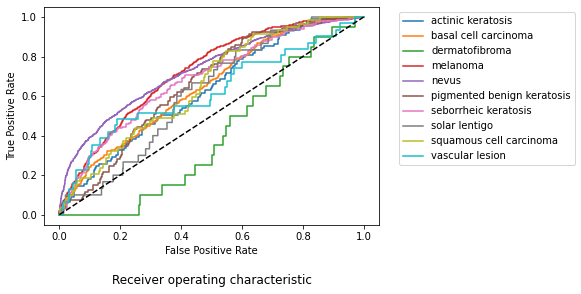

In [16]:
%matplotlib inline 

plt.rcParams['axes.titley'] = -0.3

for diagnosis in testing_set.class_indices:
    plt.plot(fpr[diagnosis], tpr[diagnosis], label=diagnosis)
    
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(bbox_to_anchor=(1.6, 1), loc="upper right")
plt.show()

### GradCam

In [17]:
melanoma_im_path = f"{os.environ['SCRATCH']}/isic-archive/ISIC_0000031.jpg"

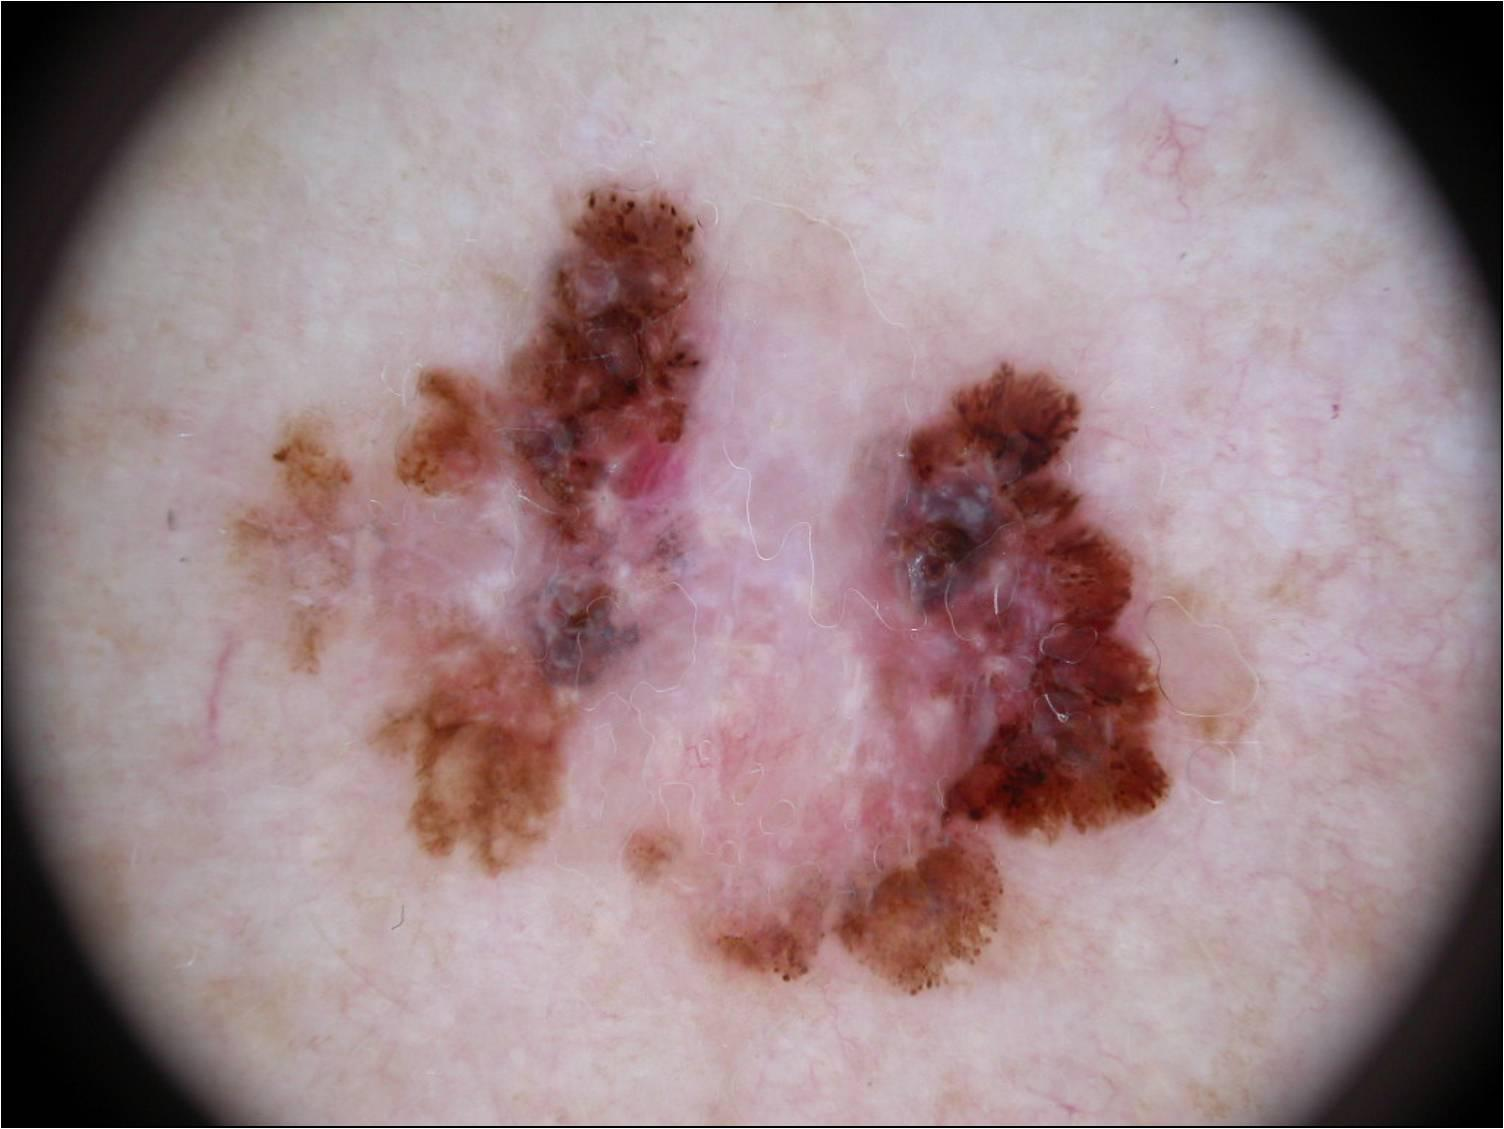

In [18]:
display(Image(melanoma_im_path, width=600))

In [19]:
img_array = tf.keras.applications.inception_resnet_v2.preprocess_input(get_img_array(melanoma_im_path, size=(299, 299)))

In [20]:
heatmap = make_gradcam_heatmap(img_array, model.o_model, 'conv_7b')

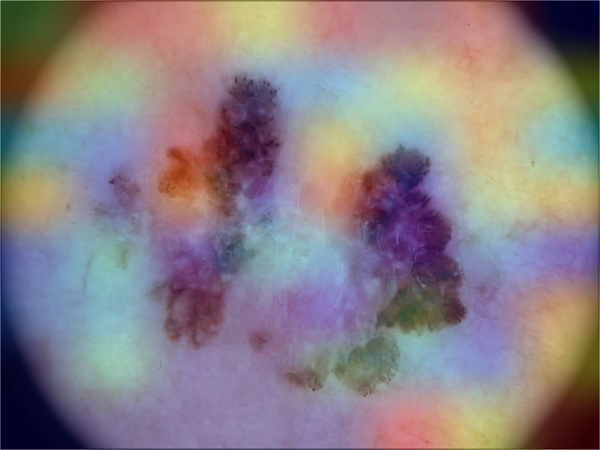

In [21]:
display_gradcam(melanoma_im_path, heatmap)